In [2]:
import os, sys
os.chdir(os.path.dirname(os.getcwd()))

In [3]:
pwd

'/home/vectech1/Documents/repos/novel-species-detection'

In [14]:
import shutil
import glob
import time
import argparse
import json
from easydict import EasyDict
import copy
import pprint
from collections import namedtuple

import math
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', None)
import cv2
from PIL import Image
import matplotlib.pyplot as plt


## Plots

In [23]:
cm_df = pd.read_csv('./subm/bigset/avg/confusion.csv',index_col=0)
cm = cm_df.to_numpy()
species= ['Ae. aegypti', 'Ae. albopictus', 'Ae. atlanticus', 'Ae. canadensis', 'Ae. dorsalis', 'Ae. flavescens', 
          'Ae. infirmatus', 'Ae. japonicus', 'Ae. nigromaculis', 'Ae. sollicitans', 'Ae. taeniorhynchus', 
          'Ae. triseriatus sl', 'Ae. trivittatus', 'Ae. vexans', 'An. coustani', 'An. crucians sl', 'An. freeborni', 
          'An. funestus sl', 'An. gambiae sl', 'An. pseudopunctipennis', 'An. punctipennis', 'An. quadrimaculatus', 
          'Co. perturbans', 'Cx. coronator', 'Cx. erraticus', 'Cx. nigripalpus', 'Cx. pipiens sl', 
          'Cx. restuans', 'Cx. salinarius', 'Cus. incidens', 'Cus. inornata', 'De. cancer', 'De. cuba-1', 
          'Ma. titillans', 'Ps. ciliata', 'Ps. columbiae', 'Ps. cyanescens', 'Ps. ferox', 'Ps. pygmaea']

In [26]:
def plot_pretty_blue_confusion_matrix(classes, y_true=[], y_pred=[], cm=[],
                                      normalize=False,
                                      title=None,
                                      cmap=plt.cm.Blues,
                                      savepath=None,
                                      figsize=(48,48)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix'

    labels=list(range(0,len(classes),1))
    # Compute confusion matrix
    if (len(y_true)==0 and len(y_pred)==0) and len(cm)==0:
        sys.exit('need at least cm or the predictions and truths')
    elif len(cm)==0:
        cm = confusion_matrix(y_true, y_pred,labels=labels)
        precisions = np.diag(cm) / np.sum(cm, axis = 0)
        recalls = np.diag(cm) / np.sum(cm, axis = 1)
        print("Precision: ", np.round(precisions, 4))
        print("Recall: ", np.round(recalls, 4))

    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        acc = 0
        for i in range(len(classes)):
            acc += cm[i][i]
        acc = acc/len(classes)
        print('Avg Acc',acc)
    else:
        print("Confusion matrix")


    # print(cm)
    save_df = pd.DataFrame(data=cm, columns=classes)
    save_df.index = classes
    if savepath is not None:
        save_df.to_csv(savepath.replace(savepath.split('/')[-1],'confusion.csv'), index=True)
    else:
        save_df.to_csv('./subm/confusion.csv', index=True)

    fig, ax = plt.subplots(figsize=figsize)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.xticks(fontsize=round(figsize[0]*.45))
    plt.yticks(fontsize=round(figsize[0]*.45))
    ax.set_xlabel('True label',fontsize=round(figsize[0]*.65))
    ax.set_ylabel('Predicted label',fontsize=round(figsize[0]*.65))
    plt.title(label=title,fontsize=round(figsize[0]*1))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    # ax.tick_params(direction='out', length=6, width=2, colors='r',
    #            grid_color='r', grid_alpha=0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # plt.tight_layout()
    plt.gcf().subplots_adjust(bottom=0.25)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm[i, j]
            if math.isnan(val):
                val = 0.0
            ax.text(j, i, format(val, fmt),
                    ha="center", va="center", size=round(figsize[0]*.4),
                    color="white" if cm[i, j] > thresh else "black")
    if savepath is not None:
        fig.savefig(savepath)
    return ax

Normalized confusion matrix
Avg Acc 0.8447449623811107


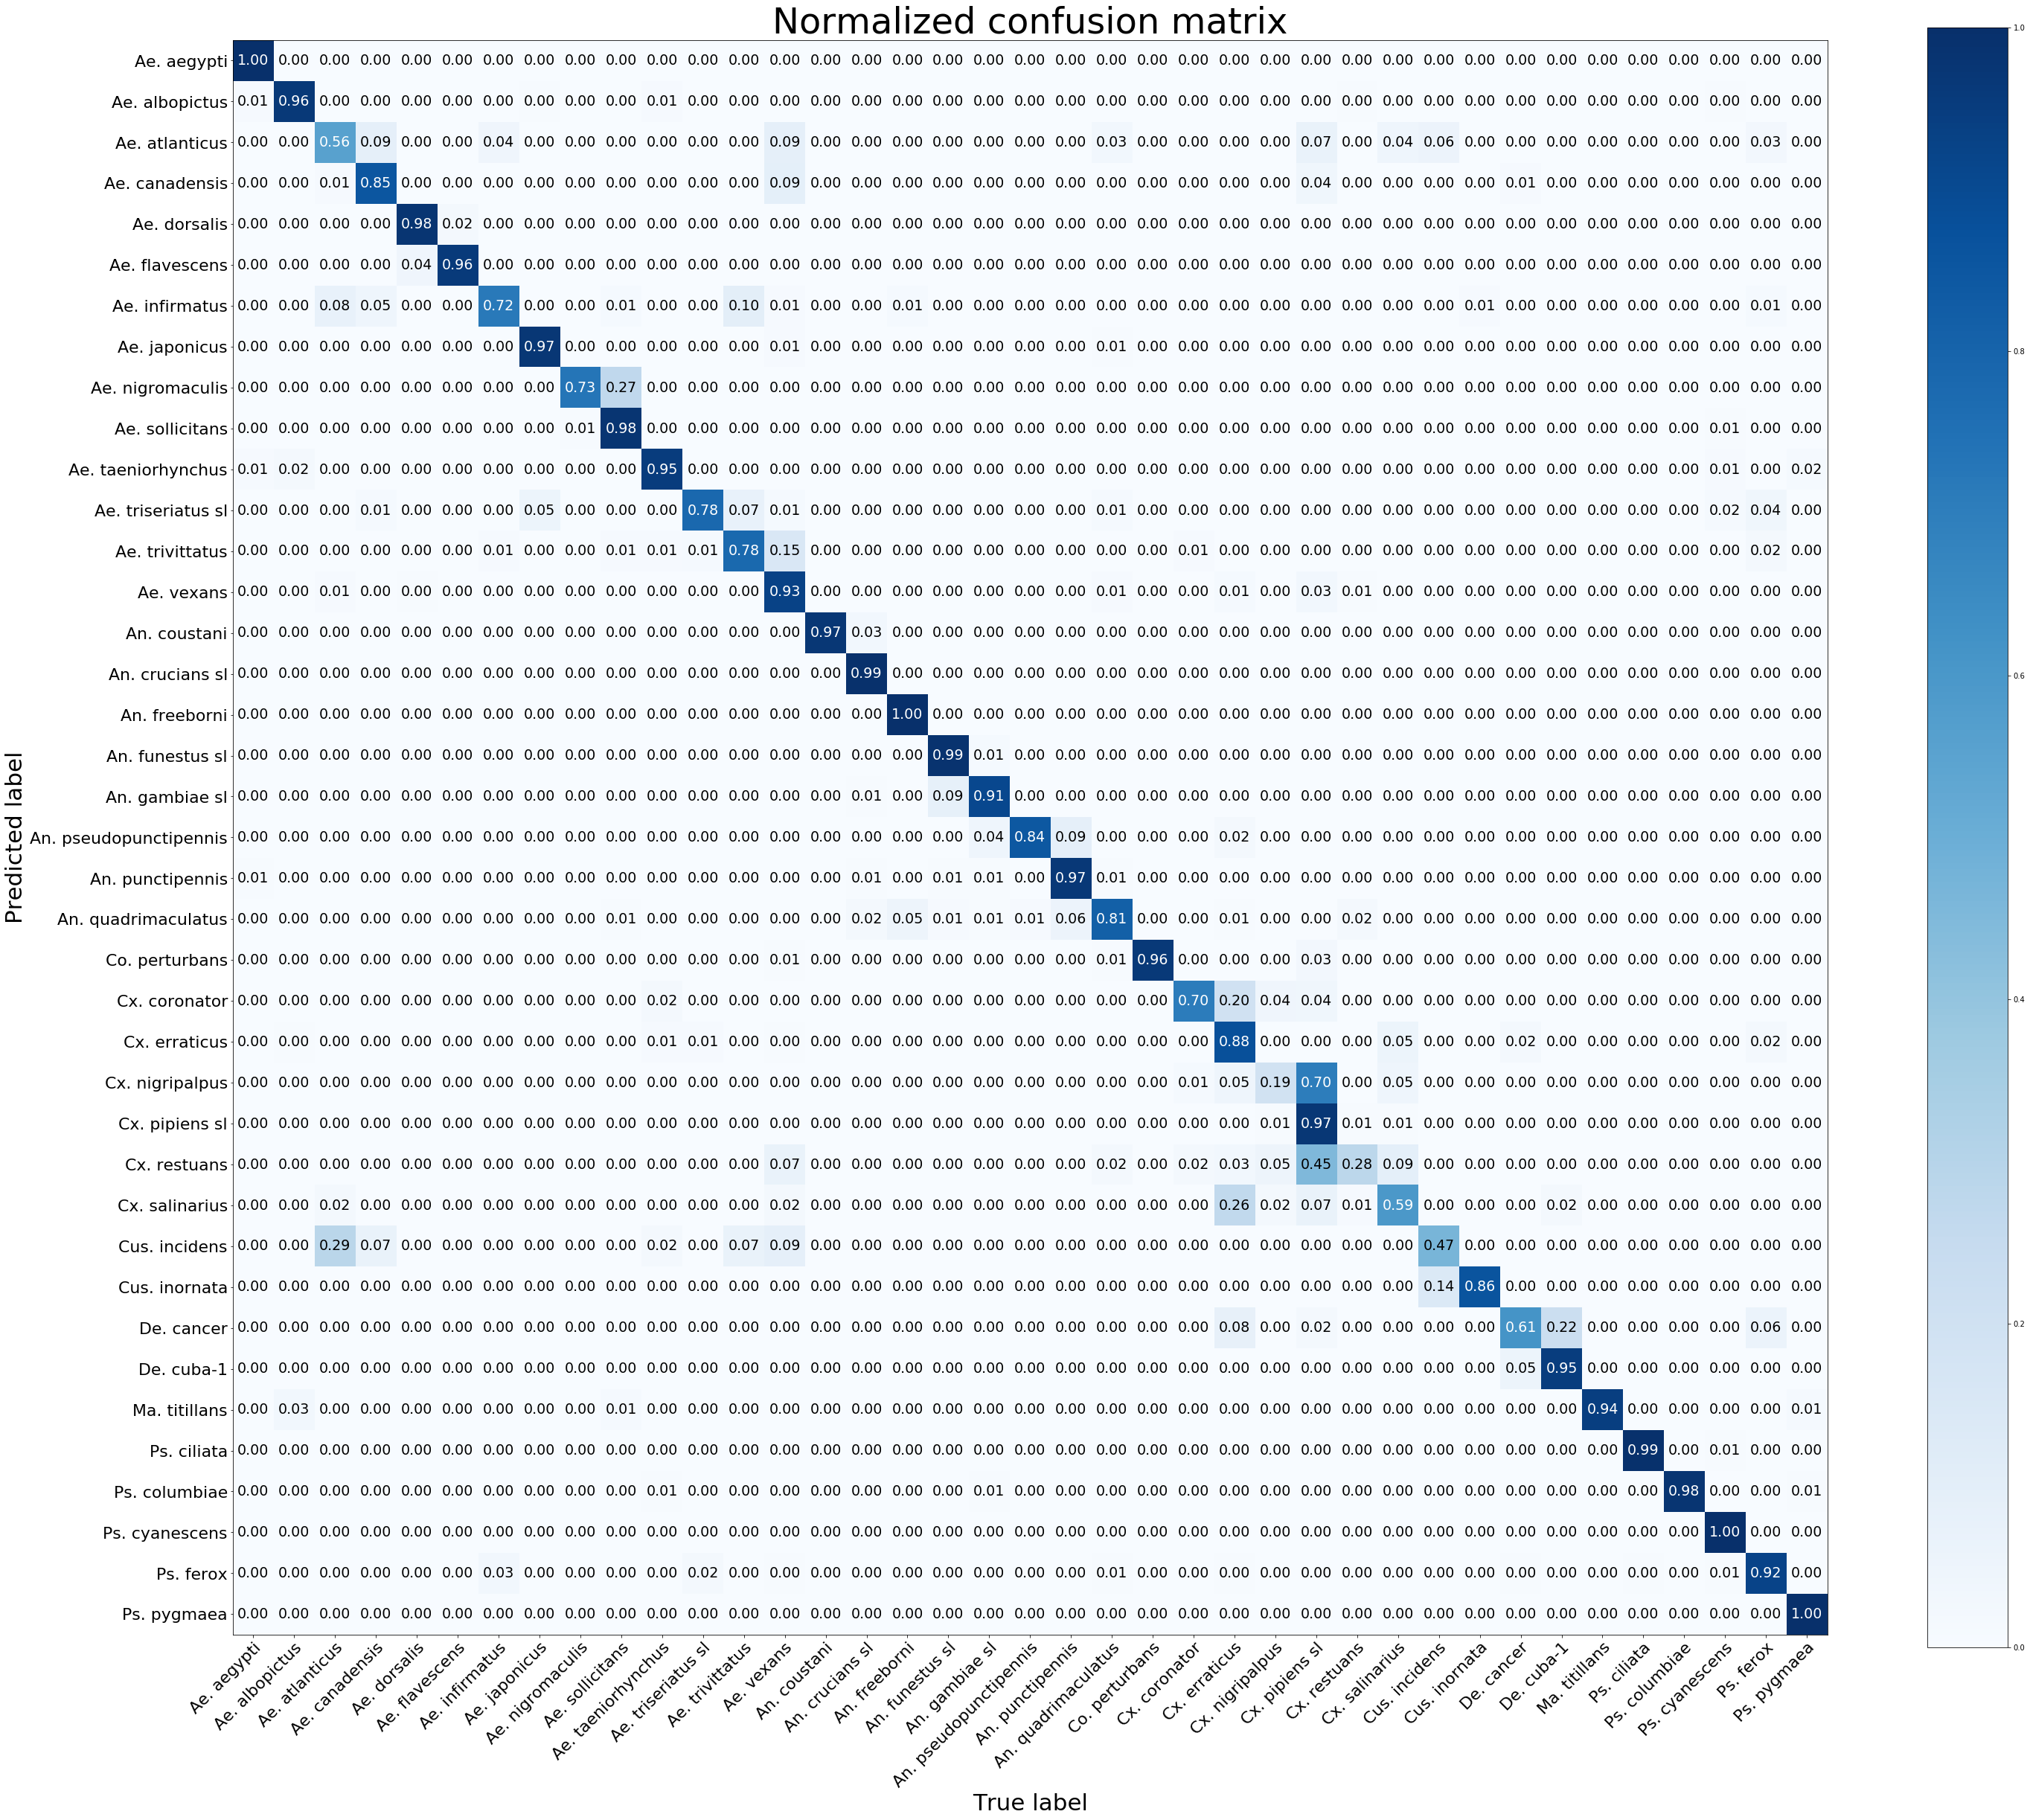

In [27]:
# from post_plots import plot_pretty_blue_confusion_matrix 
plot_pretty_blue_confusion_matrix(species,cm=cm,
                      normalize=True,
                      savepath='./subm/bigset/avg/confusion_matrix.png')

In [18]:
## 16/20 class independent confusion

In [19]:
species_lookup= {'aedes aedes_aegypti': 'Ae. aegypti',
                'aedes aedes_albopictus': 'Ae. albopictus',
                'aedes aedes_dorsalis': 'Ae. dorsalis',
                'aedes aedes_japonicus': 'Ae. japonicus',
                'aedes aedes_sollicitans': 'Ae. sollicitans',
                'aedes aedes_taeniorhynchus': 'Ae. taeniorhynchus',
                'aedes aedes_vexans': 'Ae. vexans',
                'anopheles anopheles_coustani': 'An. coustani',
                'anopheles anopheles_crucians': 'An. crucians sl',
                'anopheles anopheles_freeborni': 'An. freeborni',
                'anopheles anopheles_funestus': 'An. funestus sl',
                'anopheles anopheles_gambiae': 'An. gambiae sl',
                'anopheles anopheles_punctipennis': 'An. punctipennis',
                'anopheles anopheles_quadrimaculatus': 'An. quadrimaculatus',
                'culex culex_erraticus': 'Cx. erraticus',
                'culex culex_pipiens_sl': 'Cx. pipiens sl',
                'culex culex_salinarius': 'Cx. salinarius',
                'psorophora psorophora_columbiae': 'Ps. columbiae',
                'psorophora psorophora_cyanescens': 'Ps. cyanescens',
                'psorophora psorophora_ferox': 'Ps. ferox'}
species=[species_lookup[sp] for sp in species_lookup.keys()]
cm_avg = np.zeros((len(species),len(species)))
cm_iters = np.zeros((len(species),len(species)))
cm_avg = np.zeros((len(species),len(species)))

for fold in [1,2,3,4,5]:
    cm_df = pd.read_csv('./subm/paper_redo/fold{}/confusion.csv'.format(fold),index_col=0)
    cm = cm_df.to_numpy()
    for truth in cm_df.columns:
        itruth = species.index(species_lookup[truth])
        for pred in cm_df.columns:
            ipred = species.index(species_lookup[pred])
            cm_avg[itruth,ipred]+= cm_df.loc[truth,pred]
            cm_iters[itruth,ipred]+=1
print(cm_iters)
cm_avg=np.divide(cm_avg,cm_iters)
np.sum(cm_avg,axis=0)

[[4. 3. 3. 3. 4. 3. 3. 3. 3. 4. 3. 3. 3. 3. 3. 4. 3. 3. 3. 3.]
 [3. 4. 3. 3. 3. 3. 4. 3. 3. 3. 4. 3. 3. 3. 3. 3. 4. 3. 3. 3.]
 [3. 3. 4. 3. 3. 3. 3. 4. 3. 3. 3. 4. 3. 3. 3. 3. 3. 4. 3. 3.]
 [3. 3. 3. 4. 3. 3. 3. 3. 4. 3. 3. 3. 3. 3. 4. 3. 3. 3. 3. 4.]
 [4. 3. 3. 3. 4. 3. 3. 3. 3. 4. 3. 3. 3. 3. 3. 4. 3. 3. 3. 3.]
 [3. 3. 3. 3. 3. 4. 3. 3. 3. 3. 3. 3. 4. 4. 3. 3. 3. 3. 4. 3.]
 [3. 4. 3. 3. 3. 3. 4. 3. 3. 3. 4. 3. 3. 3. 3. 3. 4. 3. 3. 3.]
 [3. 3. 4. 3. 3. 3. 3. 4. 3. 3. 3. 4. 3. 3. 3. 3. 3. 4. 3. 3.]
 [3. 3. 3. 4. 3. 3. 3. 3. 4. 3. 3. 3. 3. 3. 4. 3. 3. 3. 3. 4.]
 [4. 3. 3. 3. 4. 3. 3. 3. 3. 4. 3. 3. 3. 3. 3. 4. 3. 3. 3. 3.]
 [3. 4. 3. 3. 3. 3. 4. 3. 3. 3. 4. 3. 3. 3. 3. 3. 4. 3. 3. 3.]
 [3. 3. 4. 3. 3. 3. 3. 4. 3. 3. 3. 4. 3. 3. 3. 3. 3. 4. 3. 3.]
 [3. 3. 3. 3. 3. 4. 3. 3. 3. 3. 3. 3. 4. 4. 3. 3. 3. 3. 4. 3.]
 [3. 3. 3. 3. 3. 4. 3. 3. 3. 3. 3. 3. 4. 4. 3. 3. 3. 3. 4. 3.]
 [3. 3. 3. 4. 3. 3. 3. 3. 4. 3. 3. 3. 3. 3. 4. 3. 3. 3. 3. 4.]
 [4. 3. 3. 3. 4. 3. 3. 3. 3. 4. 3. 3. 3. 3. 3. 4. 3. 3.

array([1.02898541, 1.02179808, 1.        , 0.99320696, 0.99796846,
       0.9929792 , 1.02527188, 0.99137931, 1.06807339, 1.09819599,
       1.10079207, 0.96840763, 0.98600113, 0.85707245, 1.19448476,
       1.11585114, 0.84758164, 0.98712953, 1.01368564, 0.95209142])

Normalized confusion matrix
Avg Acc 0.9495981697535975


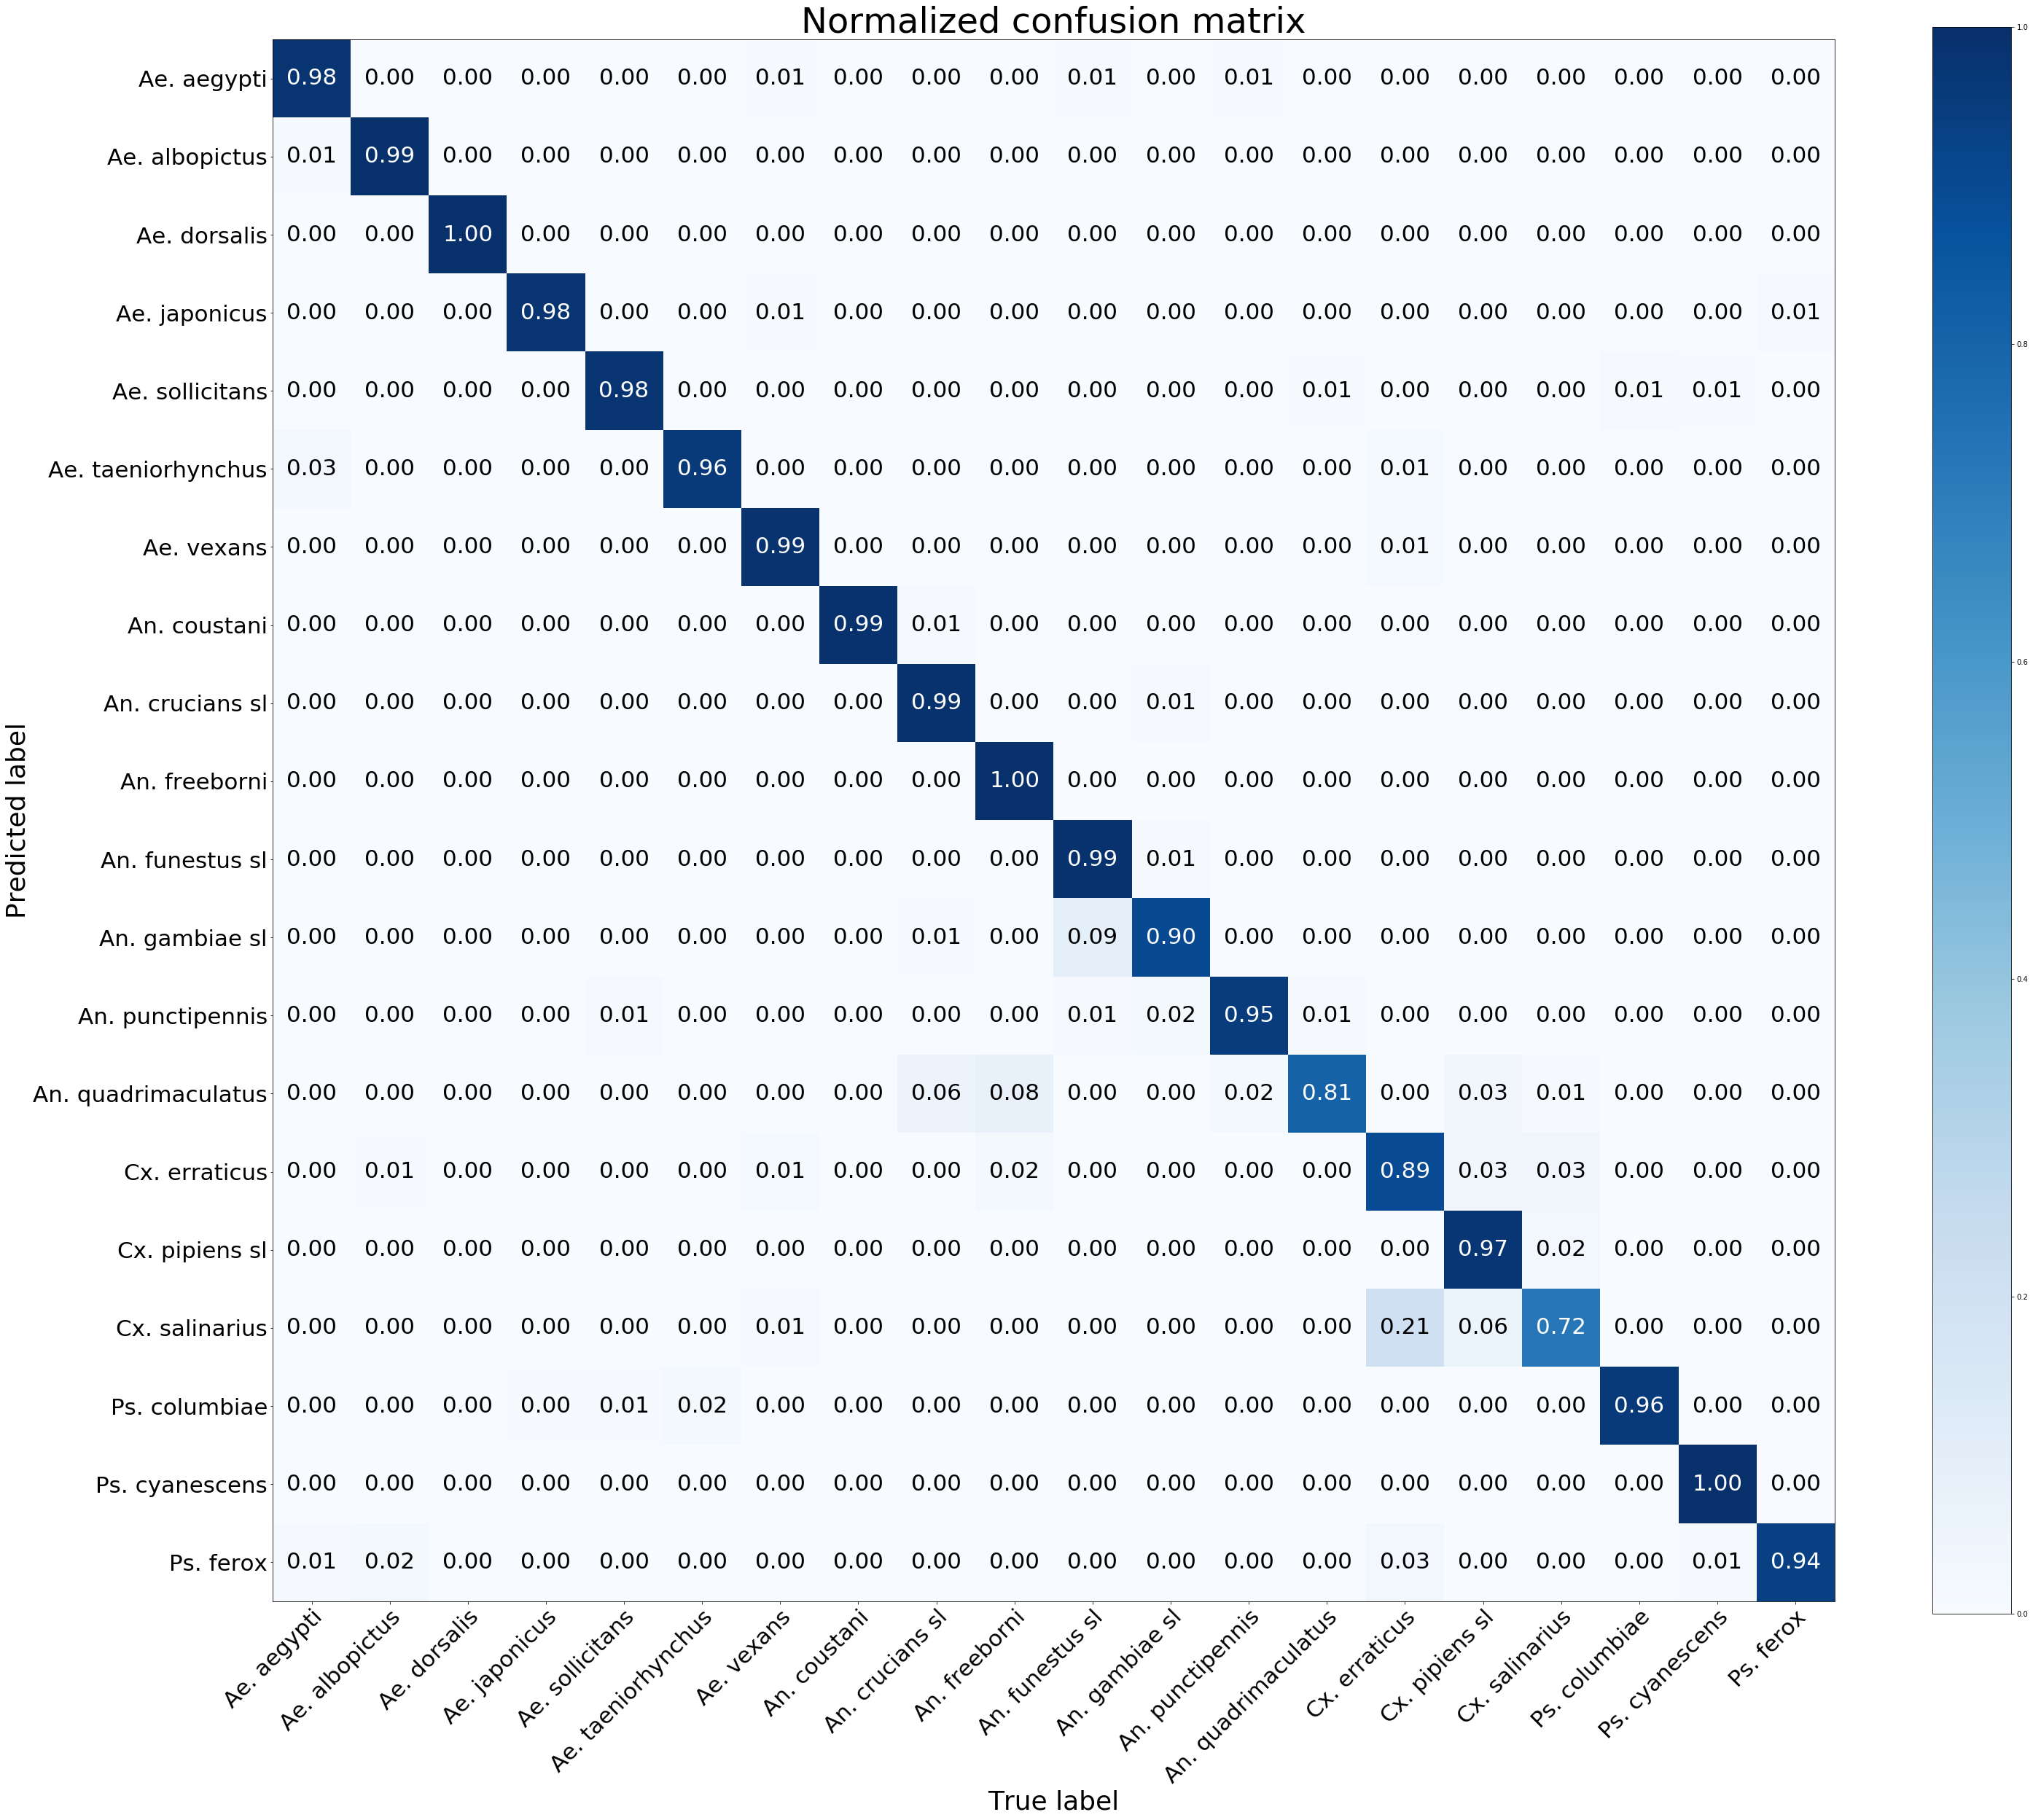

In [20]:
plot_pretty_blue_confusion_matrix(species,cm=cm_avg,
                      normalize=True,
                      savepath='./subm/paper_redo/closedavg/confusion_matrix.png')